<a href="https://colab.research.google.com/github/nicholasanthonys/learn-gan/blob/main/MNIST_VariationalAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import metrics
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


The next step is to set global variables and hyperparameters, as shown in listing 2.2.
They should all be familiar: the original dimensions are 28 × 28, which is the standard
size. We then flatten the images from the MNIST dataset, to get a vector of 784 (28 ×
28) dimensions. And we will also have a single intermediate layer of, say, 256 nodes.
But do experiment with other sizes; that’s why it’s a hyperparameter!


In [51]:
batch_size = 100
# Height × width of  MNIST image
original_dim = 28*28
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0


Creating the sampling helper function : 
|

In [52]:
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


Creating the encoder : 

In [53]:
# Input to our encoder
x = Input(shape=(original_dim), name="input")
# Intermediate layer
h = Dense(intermediate_dim, activation='relu', name='encoding')(x)
# Defines the mean of the latent space
z_mean = Dense(latent_dim, name="mean")(h)

# Defines the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(h)
# Note that output_shape isn’t necessary with the TensorFlow backend.
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# Defines the encoder as a Keras mode
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")


Now comes the tricky part, where we sample from the latent space and then feed this
information through to the decoder. But think for a bit how z_mean and z_log_var are
connected: they are both connected to h with a dense layer of two nodes, which are
the defining characteristics of a normal distribution: mean and variance. The preced-
ing sampling function is implemented as shown in the following listing.


Writing the decoder


In [54]:
# input to the decoder
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# Takes the latent space to the intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# Gets the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
# defines the decoder as a Keras model
decoder = Model(input_decoder, x_decoded, name="decoder")


We can now combine the encoder and the decoder into a single VAE model.


In [55]:
# Grabs the output. Recall that we need to grab the third element, our sampling z.
output_combined = decoder(encoder(x)[2])
# Links the input and the overal output
vae = Model(x, output_combined)
# Prints out what the overal model looks like
vae.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


Defining our loss function

In [56]:
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,
            z_log_var=z_log_var, z_mean=z_mean,
            original_dim=original_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(
        1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss


Compile our model

In [57]:
vae.compile(optimizer='rmsprop', loss=vae_loss)

Here you can see where using binary cross-entropy and KL divergence add together to
form overall loss. KL divergence measures the difference between distributions; imag-
ine the two blobs from figure 2.5 and then measuring the volume of overlap. Binary
cross-entropy is one of the common loss functions for two-class classification: here we
simply compare each grayscale pixel value of x to the value in x_decoded_mean, which
is the reconstruction we were talking about earlier. If you are still confused about this
paragraph after the following definition, chapter 5 provides more details on measur-
ing differences between distributions.


Then we define the model to start at x and end at x_decoded_mean. The model is com-
piled using RMSprop, but we could use Adam or vanilla stochastic gradient descent
(SGD). As with any deep learning system, we are using backpropagated errors to navi-
gate the parameter space. We are always using some type of gradient descent, but in
general, people rarely try any other than the three mentioned here: Adam, SGD, or
RMSprop.


Creating the train/test split

In [58]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


We normalize the data and reshape the train set and test set to be one 784-digit-long
array per example instead of a 28 × 28 matrix.
Then we apply the fit function, using shuffling to get a realistic (nonordered)
dataset. We also use validation data to monitor progress as we train:


In [59]:
vae.fit(x_train, x_train, shuffle=True, epochs=epochs, batch_size=batch_size)


Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 9s 147us/sample - loss: 190.3013
Epoch 2/50
60000/60000 [==============================] - 8s 137us/sample - loss: 171.3306
Epoch 3/50
60000/60000 [==============================] - 8s 137us/sample - loss: 167.1446
Epoch 4/50
60000/60000 [==============================] - 8s 136us/sample - loss: 164.8049
Epoch 5/50
60000/60000 [==============================] - 8s 139us/sample - loss: 163.1188
Epoch 6/50
60000/60000 [==============================] - 8s 135us/sample - loss: 161.5188
Epoch 7/50
60000/60000 [==============================] - 8s 139us/sample - loss: 160.1300
Epoch 8/50
60000/60000 [==============================] - 8s 139us/sample - loss: 159.0018
Epoch 9/50
60000/60000 [==============================] - 8s 140us/sample - loss: 158.1426
Epoch 10/50
60000/60000 [==============================] - 8s 140us/sample - loss: 157.4148
Epoch 11/50
60000/60000 [==============================] - 9s 147u

Next we grab just the "data-generating" part of the model.
In the book we explained how we generate the new images in Figure 2.3.

We will now generate the Figure in 2.6.

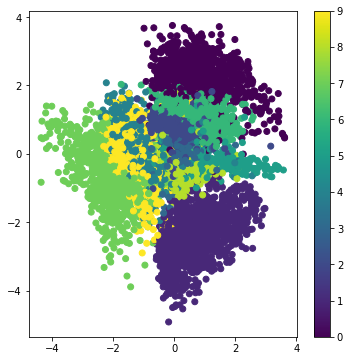

In [62]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

Last but not least, let's generate Figure 2.7.¶
The only tricky part here is that we have to create a grid over which we interpolate. Which we do by using np.linspace, which enables us to move between min and max value in step_size.

We then just generate a digit for each sample in the for loop and display!



/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


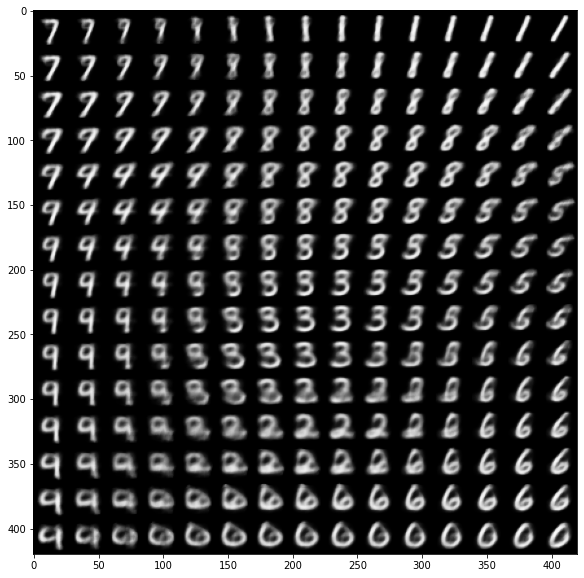

In [65]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()